In [17]:
# ========================================
# 03_deeplabv3_training.ipynb
# DeepLabV3+ Model Training
# ========================================

# ----- Cell 1: Mount Google Drive -----
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# ----- Cell 2: Setup project paths -----
import os
import sys

PROJECT_ROOT = '/content/drive/MyDrive/SHBT 261/Mini_Project_2'
os.chdir(PROJECT_ROOT)

print(f"Working directory: {os.getcwd()}")
print(f"Project structure:")
!ls -lh

Working directory: /content/drive/MyDrive/SHBT 261/Mini_Project_2
Project structure:
total 1.9M
drwx------ 2 root root 4.0K Nov 15 04:09  data
-rw------- 1 root root 1.9M Nov 15 02:42 'Mini-Project 2.pdf'
drwx------ 2 root root 4.0K Nov 15 04:09  models
drwx------ 2 root root 4.0K Nov 15 04:09  notebooks
drwx------ 2 root root 4.0K Nov 15 04:09  results
-rw------- 1 root root   53 Nov 15 08:45  voc_data_path.txt


In [19]:
# ----- Cell 3: Install dependencies -----
!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q kagglehub

print("✓ Dependencies installed")

✓ Dependencies installed


In [20]:
# ----- Cell 4: Import libraries -----
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
import segmentation_models_pytorch as smp

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from datetime import datetime

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [21]:
# ----- Cell 5: Load dataset path and setup data -----
import kagglehub

print("Loading Pascal VOC 2007 dataset...")
dataset_path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

# Find VOC root
trainval_candidates = [
    'VOCtrainval_06-Nov-2007',
    'voctrainval_06-nov-2007',
]

VOC_ROOT = None
for candidate in trainval_candidates:
    candidate_path = os.path.join(dataset_path, candidate)
    if os.path.exists(os.path.join(candidate_path, 'VOCdevkit', 'VOC2007')):
        VOC_ROOT = candidate_path
        break

print(f"✓ VOC_ROOT: {VOC_ROOT}")

# Define classes
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES)
print(f"✓ Number of classes: {NUM_CLASSES}")

Loading Pascal VOC 2007 dataset...
Using Colab cache for faster access to the 'pascal-voc-2007' dataset.
✓ VOC_ROOT: /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007
✓ Number of classes: 21


In [22]:
# ----- Cell 5: Load dataset path and setup data -----
import kagglehub

print("Loading Pascal VOC 2007 dataset...")
dataset_path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

# Find VOC root
trainval_candidates = [
    'VOCtrainval_06-Nov-2007',
    'voctrainval_06-nov-2007',
]

VOC_ROOT = None
for candidate in trainval_candidates:
    candidate_path = os.path.join(dataset_path, candidate)
    if os.path.exists(os.path.join(candidate_path, 'VOCdevkit', 'VOC2007')):
        VOC_ROOT = candidate_path
        break

print(f"✓ VOC_ROOT: {VOC_ROOT}")

# Define classes
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES)
print(f"✓ Number of classes: {NUM_CLASSES}")

Loading Pascal VOC 2007 dataset...
Using Colab cache for faster access to the 'pascal-voc-2007' dataset.
✓ VOC_ROOT: /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007
✓ Number of classes: 21


In [23]:
# ----- Cell 6: Data transforms with augmentation -----
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Training transforms (with augmentation)
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Validation transforms (no augmentation)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

print("✓ Data transforms defined")

✓ Data transforms defined


In [24]:
# ----- Cell 7: Custom Dataset wrapper -----
from torch.utils.data import Dataset
from PIL import Image

class VOCSegmentationAlbumentations(Dataset):
    """
    Wrapper for VOCSegmentation to use Albumentations transforms
    """
    def __init__(self, root, year, image_set, transform=None):
        self.voc = VOCSegmentation(
            root=root,
            year=year,
            image_set=image_set,
            download=False
        )
        self.transform = transform

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        image, mask = self.voc[idx]

        # Convert PIL to numpy
        image = np.array(image)
        mask = np.array(mask)

        # Clean mask
        mask[mask == 255] = 0

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # Convert mask to long tensor
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        mask = mask.long()

        return image, mask

print("✓ Custom dataset class defined")

✓ Custom dataset class defined


In [32]:
# ----- Cell 8: Create datasets and dataloaders -----
# Create datasets
train_dataset = VOCSegmentationAlbumentations(
    root=VOC_ROOT,
    year="2007",
    image_set="train",
    transform=train_transform
)

val_dataset = VOCSegmentationAlbumentations(
    root=VOC_ROOT,
    year="2007",
    image_set="val",
    transform=val_transform
)

# Create dataloaders
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True  # Drop last incomplete batch to avoid BatchNorm error
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False  # Keep all validation samples
)

print(f"✓ Train samples: {len(train_dataset)}")
print(f"✓ Val samples: {len(val_dataset)}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Val batches: {len(val_loader)}")

✓ Train samples: 209
✓ Val samples: 213
✓ Batch size: 8
✓ Train batches: 26
✓ Val batches: 27


In [33]:
# ----- Cell 9: Define DeepLabV3+ model -----
# Create DeepLabV3+ model using segmentation_models_pytorch
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",        # Encoder backbone
    encoder_weights="imagenet",     # Use pretrained weights
    in_channels=3,                  # RGB images
    classes=NUM_CLASSES,            # 21 classes
)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"✓ DeepLabV3+ model created")
print(f"✓ Encoder: ResNet50 (pretrained on ImageNet)")
print(f"✓ Device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")

✓ DeepLabV3+ model created
✓ Encoder: ResNet50 (pretrained on ImageNet)
✓ Device: cuda
✓ Total parameters: 26,682,725
✓ Trainable parameters: 26,682,725


In [34]:
# ----- Cell 10: Define loss function and optimizer -----
# Loss function (Cross Entropy)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print(f"✓ Loss: CrossEntropyLoss")
print(f"✓ Optimizer: Adam (lr={LEARNING_RATE})")
print(f"✓ Scheduler: ReduceLROnPlateau")

✓ Loss: CrossEntropyLoss
✓ Optimizer: Adam (lr=0.0001)
✓ Scheduler: ReduceLROnPlateau


In [35]:
# ----- Cell 11: Define metrics -----
def calculate_iou(pred, target, num_classes=21):
    """
    Calculate IoU for each class
    """
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())

    return ious

def calculate_pixel_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred.view(-1)
    target = target.view(-1)
    correct = (pred == target).sum().float()
    total = target.numel()
    return (correct / total).item()

print("✓ Metrics defined: IoU, Pixel Accuracy")

✓ Metrics defined: IoU, Pixel Accuracy


In [36]:
# ----- Cell 12: Training function -----
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    running_iou = []
    running_acc = 0.0

    pbar = tqdm(dataloader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate metrics
        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks, NUM_CLASSES)
        batch_acc = calculate_pixel_accuracy(preds, masks)

        # Update running metrics
        running_loss += loss.item()
        running_iou.append(batch_iou)
        running_acc += batch_acc

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{batch_acc:.4f}'
        })

    # Calculate epoch metrics
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = np.nanmean(running_iou)
    epoch_acc = running_acc / len(dataloader)

    return epoch_loss, epoch_iou, epoch_acc

print("✓ Training function defined")

✓ Training function defined


In [37]:
# ----- Cell 13: Validation function -----
def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    running_iou = []
    running_acc = 0.0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Calculate metrics
            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks, NUM_CLASSES)
            batch_acc = calculate_pixel_accuracy(preds, masks)

            # Update running metrics
            running_loss += loss.item()
            running_iou.append(batch_iou)
            running_acc += batch_acc

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{batch_acc:.4f}'
            })

    # Calculate epoch metrics
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = np.nanmean(running_iou)
    epoch_acc = running_acc / len(dataloader)

    return epoch_loss, epoch_iou, epoch_acc

print("✓ Validation function defined")

✓ Validation function defined


In [38]:
# ----- Cell 14: Training loop -----
NUM_EPOCHS = 30

# Initialize tracking
best_val_iou = 0.0
history = {
    'train_loss': [],
    'train_iou': [],
    'train_acc': [],
    'val_loss': [],
    'val_iou': [],
    'val_acc': [],
}

# Create models directory
os.makedirs(f'{PROJECT_ROOT}/models', exist_ok=True)

print("=" * 70)
print(f"Starting DeepLabV3+ Training")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Device: {device}")
print("=" * 70)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_iou, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validate
    val_loss, val_iou, val_acc = validate(
        model, val_loader, criterion, device
    )

    # Update scheduler
    scheduler.step(val_loss)

    # Save metrics
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f} | Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': val_iou,
            'val_loss': val_loss,
        }, f'{PROJECT_ROOT}/models/deeplabv3_best.pth')
        print(f"  ✓ Best model saved! (IoU: {val_iou:.4f})")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, f'{PROJECT_ROOT}/models/deeplabv3_checkpoint_epoch_{epoch+1}.pth')
        print(f"  ✓ Checkpoint saved at epoch {epoch+1}")

# Training complete
end_time = time.time()
training_time = end_time - start_time

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)
print(f"Total training time: {training_time/60:.2f} minutes")
print(f"Best validation IoU: {best_val_iou:.4f}")
print(f"Models saved to: {PROJECT_ROOT}/models/")

Starting DeepLabV3+ Training
Epochs: 30
Device: cuda

Epoch 1/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:03<00:00,  8.54it/s, loss=2.6731, acc=0.6741]



Epoch 1 Summary:
  Train Loss: 2.4775 | Train IoU: 0.0570 | Train Acc: 0.4941
  Val Loss:   2.6978 | Val IoU:   0.1020 | Val Acc:   0.6564
  ✓ Best model saved! (IoU: 0.1020)

Epoch 2/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.84it/s, loss=1.4954, acc=0.7498]



Epoch 2 Summary:
  Train Loss: 1.7807 | Train IoU: 0.1175 | Train Acc: 0.7400
  Val Loss:   1.5867 | Val IoU:   0.1505 | Val Acc:   0.8022
  ✓ Best model saved! (IoU: 0.1505)

Epoch 3/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.54it/s, loss=1.3827, acc=0.7355]



Epoch 3 Summary:
  Train Loss: 1.3733 | Train IoU: 0.1609 | Train Acc: 0.8045
  Val Loss:   1.3262 | Val IoU:   0.1765 | Val Acc:   0.8027
  ✓ Best model saved! (IoU: 0.1765)

Epoch 4/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.77it/s, loss=1.1055, acc=0.7786]



Epoch 4 Summary:
  Train Loss: 1.1276 | Train IoU: 0.1983 | Train Acc: 0.8406
  Val Loss:   1.0617 | Val IoU:   0.2271 | Val Acc:   0.8344
  ✓ Best model saved! (IoU: 0.2271)

Epoch 5/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.63it/s, loss=0.9657, acc=0.7802]



Epoch 5 Summary:
  Train Loss: 0.9644 | Train IoU: 0.2262 | Train Acc: 0.8566
  Val Loss:   0.9294 | Val IoU:   0.2446 | Val Acc:   0.8447
  ✓ Best model saved! (IoU: 0.2446)

Epoch 6/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.91it/s, loss=0.8165, acc=0.7982]



Epoch 6 Summary:
  Train Loss: 0.8193 | Train IoU: 0.2685 | Train Acc: 0.8722
  Val Loss:   0.8047 | Val IoU:   0.2665 | Val Acc:   0.8523
  ✓ Best model saved! (IoU: 0.2665)

Epoch 7/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.54it/s, loss=0.7552, acc=0.8320]



Epoch 7 Summary:
  Train Loss: 0.6953 | Train IoU: 0.3151 | Train Acc: 0.8909
  Val Loss:   0.7326 | Val IoU:   0.2669 | Val Acc:   0.8555
  ✓ Best model saved! (IoU: 0.2669)

Epoch 8/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.44it/s, loss=0.6200, acc=0.8649]



Epoch 8 Summary:
  Train Loss: 0.6112 | Train IoU: 0.3368 | Train Acc: 0.8980
  Val Loss:   0.6669 | Val IoU:   0.2851 | Val Acc:   0.8601
  ✓ Best model saved! (IoU: 0.2851)

Epoch 9/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.09it/s, loss=0.6607, acc=0.8448]



Epoch 9 Summary:
  Train Loss: 0.5323 | Train IoU: 0.3945 | Train Acc: 0.9072
  Val Loss:   0.6438 | Val IoU:   0.2865 | Val Acc:   0.8601
  ✓ Best model saved! (IoU: 0.2865)

Epoch 10/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.51it/s, loss=0.7156, acc=0.8053]



Epoch 10 Summary:
  Train Loss: 0.4711 | Train IoU: 0.4244 | Train Acc: 0.9158
  Val Loss:   0.5857 | Val IoU:   0.3057 | Val Acc:   0.8642
  ✓ Best model saved! (IoU: 0.3057)
  ✓ Checkpoint saved at epoch 10

Epoch 11/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.42it/s, loss=0.8207, acc=0.7985]



Epoch 11 Summary:
  Train Loss: 0.4314 | Train IoU: 0.4290 | Train Acc: 0.9175
  Val Loss:   0.5727 | Val IoU:   0.2921 | Val Acc:   0.8592

Epoch 12/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:03<00:00,  7.25it/s, loss=0.7028, acc=0.8106]



Epoch 12 Summary:
  Train Loss: 0.3935 | Train IoU: 0.4595 | Train Acc: 0.9218
  Val Loss:   0.5616 | Val IoU:   0.2835 | Val Acc:   0.8578

Epoch 13/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.20it/s, loss=0.5772, acc=0.8358]



Epoch 13 Summary:
  Train Loss: 0.3546 | Train IoU: 0.4866 | Train Acc: 0.9272
  Val Loss:   0.5362 | Val IoU:   0.2925 | Val Acc:   0.8617

Epoch 14/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.84it/s, loss=0.8359, acc=0.7873]



Epoch 14 Summary:
  Train Loss: 0.3352 | Train IoU: 0.4525 | Train Acc: 0.9283
  Val Loss:   0.5455 | Val IoU:   0.2868 | Val Acc:   0.8555

Epoch 15/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.49it/s, loss=0.5881, acc=0.8437]



Epoch 15 Summary:
  Train Loss: 0.3285 | Train IoU: 0.5105 | Train Acc: 0.9268
  Val Loss:   0.5000 | Val IoU:   0.3044 | Val Acc:   0.8623

Epoch 16/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.72it/s, loss=0.6415, acc=0.8090]



Epoch 16 Summary:
  Train Loss: 0.3027 | Train IoU: 0.5242 | Train Acc: 0.9302
  Val Loss:   0.4805 | Val IoU:   0.3197 | Val Acc:   0.8685
  ✓ Best model saved! (IoU: 0.3197)

Epoch 17/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.60it/s, loss=0.4559, acc=0.8547]



Epoch 17 Summary:
  Train Loss: 0.2706 | Train IoU: 0.5607 | Train Acc: 0.9369
  Val Loss:   0.4872 | Val IoU:   0.3014 | Val Acc:   0.8646

Epoch 18/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.47it/s, loss=0.6943, acc=0.8039]



Epoch 18 Summary:
  Train Loss: 0.2596 | Train IoU: 0.5578 | Train Acc: 0.9384
  Val Loss:   0.4838 | Val IoU:   0.3065 | Val Acc:   0.8643

Epoch 19/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.75it/s, loss=0.6877, acc=0.8143]



Epoch 19 Summary:
  Train Loss: 0.2426 | Train IoU: 0.5761 | Train Acc: 0.9412
  Val Loss:   0.4719 | Val IoU:   0.3153 | Val Acc:   0.8690

Epoch 20/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.77it/s, loss=0.7540, acc=0.8110]



Epoch 20 Summary:
  Train Loss: 0.2367 | Train IoU: 0.5833 | Train Acc: 0.9420
  Val Loss:   0.4950 | Val IoU:   0.3118 | Val Acc:   0.8618
  ✓ Checkpoint saved at epoch 20

Epoch 21/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:03<00:00,  7.93it/s, loss=0.4886, acc=0.8514]



Epoch 21 Summary:
  Train Loss: 0.2251 | Train IoU: 0.6168 | Train Acc: 0.9435
  Val Loss:   0.4807 | Val IoU:   0.3039 | Val Acc:   0.8661

Epoch 22/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.06it/s, loss=0.6405, acc=0.8454]



Epoch 22 Summary:
  Train Loss: 0.2101 | Train IoU: 0.6329 | Train Acc: 0.9456
  Val Loss:   0.4701 | Val IoU:   0.3161 | Val Acc:   0.8707

Epoch 23/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.29it/s, loss=0.6210, acc=0.8363]



Epoch 23 Summary:
  Train Loss: 0.1992 | Train IoU: 0.6305 | Train Acc: 0.9483
  Val Loss:   0.4684 | Val IoU:   0.3312 | Val Acc:   0.8710
  ✓ Best model saved! (IoU: 0.3312)

Epoch 24/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.58it/s, loss=0.3686, acc=0.8780]



Epoch 24 Summary:
  Train Loss: 0.1904 | Train IoU: 0.6465 | Train Acc: 0.9493
  Val Loss:   0.4637 | Val IoU:   0.3066 | Val Acc:   0.8690

Epoch 25/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.08it/s, loss=0.4568, acc=0.8680]



Epoch 25 Summary:
  Train Loss: 0.1885 | Train IoU: 0.6430 | Train Acc: 0.9501
  Val Loss:   0.4573 | Val IoU:   0.3297 | Val Acc:   0.8731

Epoch 26/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.58it/s, loss=0.5911, acc=0.8380]



Epoch 26 Summary:
  Train Loss: 0.1764 | Train IoU: 0.6541 | Train Acc: 0.9516
  Val Loss:   0.4872 | Val IoU:   0.3068 | Val Acc:   0.8660

Epoch 27/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.33it/s, loss=0.4279, acc=0.8568]



Epoch 27 Summary:
  Train Loss: 0.1822 | Train IoU: 0.6568 | Train Acc: 0.9507
  Val Loss:   0.4814 | Val IoU:   0.3073 | Val Acc:   0.8662

Epoch 28/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.29it/s, loss=0.5573, acc=0.8239]



Epoch 28 Summary:
  Train Loss: 0.1748 | Train IoU: 0.6632 | Train Acc: 0.9508
  Val Loss:   0.4689 | Val IoU:   0.3258 | Val Acc:   0.8725

Epoch 29/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.15it/s, loss=0.4277, acc=0.8699]



Epoch 29 Summary:
  Train Loss: 0.1608 | Train IoU: 0.6775 | Train Acc: 0.9551
  Val Loss:   0.4567 | Val IoU:   0.3135 | Val Acc:   0.8711

Epoch 30/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.05it/s, loss=0.4601, acc=0.8656]



Epoch 30 Summary:
  Train Loss: 0.1649 | Train IoU: 0.6521 | Train Acc: 0.9530
  Val Loss:   0.4790 | Val IoU:   0.3163 | Val Acc:   0.8690
  ✓ Checkpoint saved at epoch 30

TRAINING COMPLETE!
Total training time: 4.17 minutes
Best validation IoU: 0.3312
Models saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/


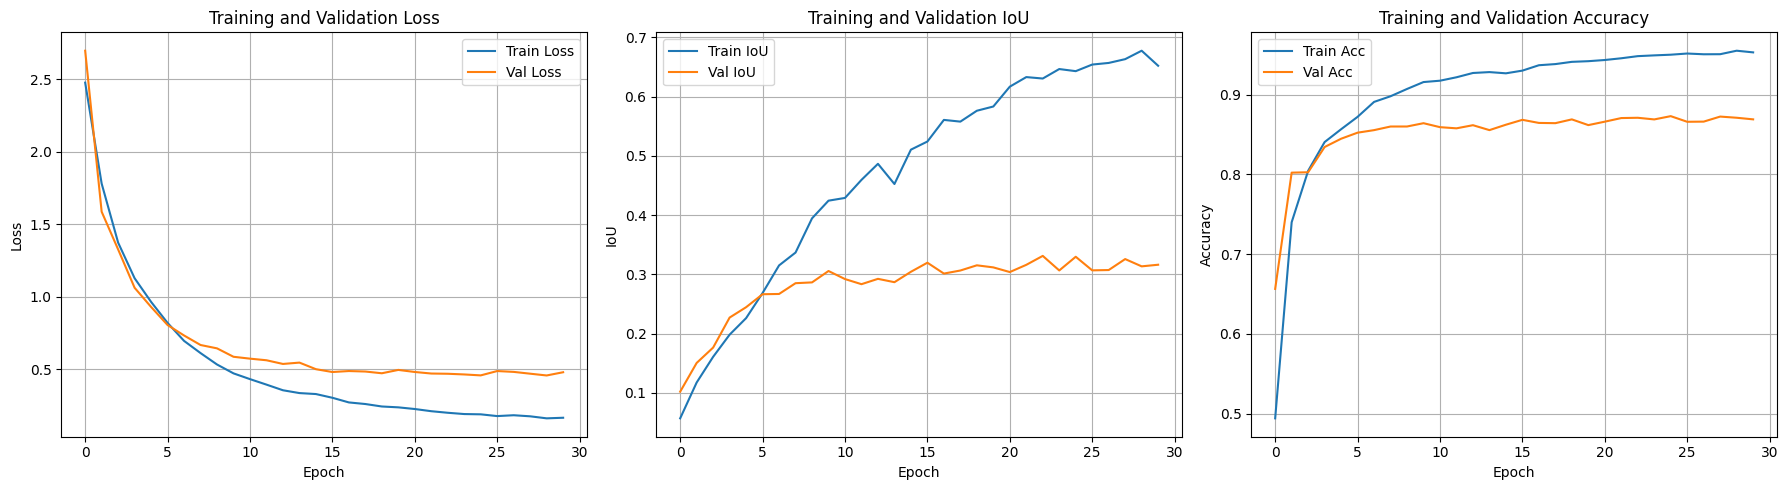

✓ Training history saved


In [39]:
# ----- Cell 15: Plot training history -----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot IoU
axes[1].plot(history['train_iou'], label='Train IoU')
axes[1].plot(history['val_iou'], label='Val IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training and Validation IoU')
axes[1].legend()
axes[1].grid(True)

# Plot Accuracy
axes[2].plot(history['train_acc'], label='Train Acc')
axes[2].plot(history['val_acc'], label='Val Acc')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Training and Validation Accuracy')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(f'{PROJECT_ROOT}/results/deeplabv3_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training history saved")

In [40]:
# ----- Cell 16: Save final model -----
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'best_val_iou': best_val_iou,
    'training_time': training_time,
}, f'{PROJECT_ROOT}/models/deeplabv3_final.pth')

print(f"✓ Final model saved to: {PROJECT_ROOT}/models/deeplabv3_final.pth")

✓ Final model saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/deeplabv3_final.pth


In [41]:
# ----- Cell 17: Load best model for inference -----
checkpoint = torch.load(f'{PROJECT_ROOT}/models/deeplabv3_best.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Best model loaded (from epoch {checkpoint['epoch']+1})")
print(f"  Validation IoU: {checkpoint['val_iou']:.4f}")
print(f"  Validation Loss: {checkpoint['val_loss']:.4f}")

✓ Best model loaded (from epoch 23)
  Validation IoU: 0.3312
  Validation Loss: 0.4684


Visualizing predictions on validation set...
✓ Predictions saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/deeplabv3_predictions.png


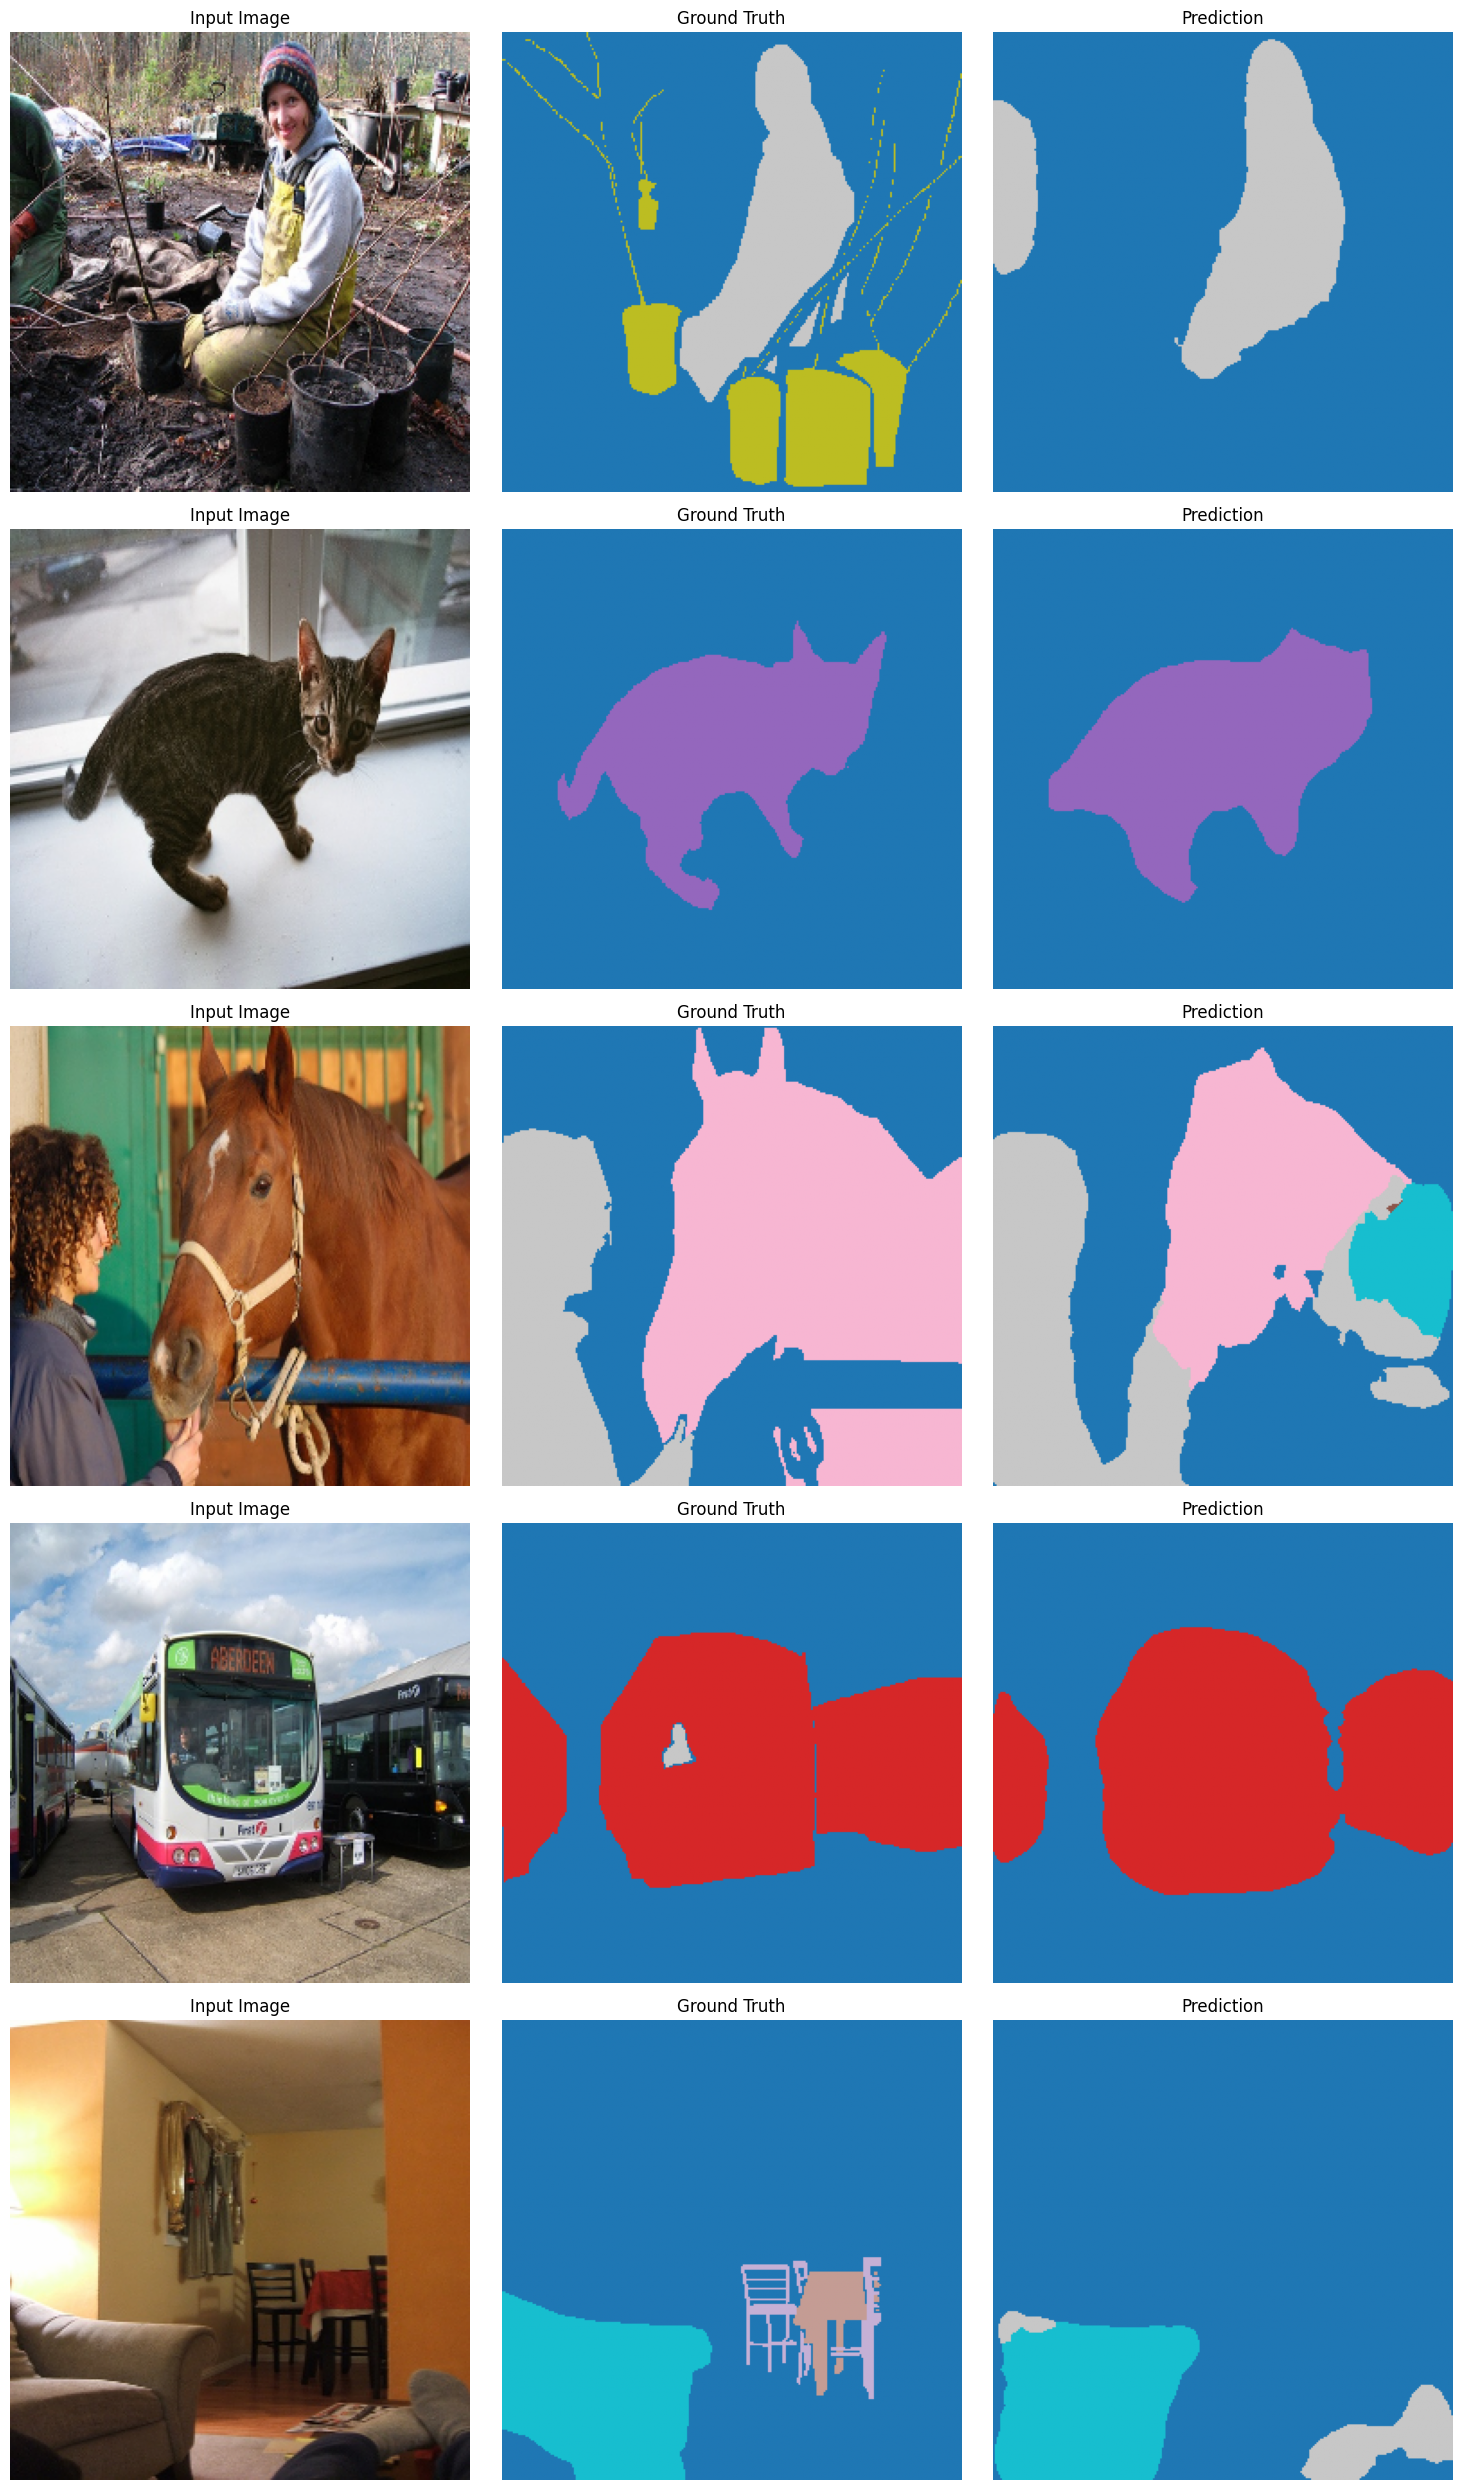

In [42]:
# ----- Cell 18: Visualize predictions -----
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, device, num_samples=5, save_dir=None):
    """
    Visualize model predictions
    """
    model.eval()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(0, len(dataset))
            image, mask = dataset[idx]

            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            # Denormalize image
            img_display = image.cpu().numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)

            mask_gt = mask.cpu().numpy()

            # Plot
            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_gt, cmap='tab20', vmin=0, vmax=20)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred, cmap='tab20', vmin=0, vmax=20)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()

    if save_dir:
        save_path = os.path.join(save_dir, 'deeplabv3_predictions.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Predictions saved to: {save_path}")

    plt.show()

print("Visualizing predictions on validation set...")
visualize_predictions(
    model,
    val_dataset,
    device,
    num_samples=5,
    save_dir=f'{PROJECT_ROOT}/results'
)

In [43]:
# ----- Cell 19: Calculate final metrics -----
def evaluate_model(model, dataloader, device, num_classes=21):
    """
    Comprehensive evaluation
    """
    model.eval()

    all_ious = []
    all_accs = []
    class_ious = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            batch_iou = calculate_iou(preds, masks, num_classes)
            batch_acc = calculate_pixel_accuracy(preds, masks)

            all_ious.append(batch_iou)
            all_accs.append(batch_acc)

            for cls in range(num_classes):
                if not np.isnan(batch_iou[cls]):
                    class_ious[cls].append(batch_iou[cls])

    mean_iou = np.nanmean(all_ious)
    mean_acc = np.mean(all_accs)
    per_class_iou = [np.mean(ious) if len(ious) > 0 else 0.0 for ious in class_ious]

    return mean_iou, mean_acc, per_class_iou

print("Evaluating DeepLabV3+ on validation set...")
val_iou, val_acc, per_class_iou = evaluate_model(model, val_loader, device)

print("\n" + "=" * 70)
print("FINAL VALIDATION METRICS")
print("=" * 70)
print(f"Mean IoU: {val_iou:.4f}")
print(f"Pixel Accuracy: {val_acc:.4f}")
print("\nPer-class IoU:")
print("-" * 70)
for idx, iou in enumerate(per_class_iou):
    print(f"  {idx:2d}. {VOC_CLASSES[idx]:15s}: {iou:.4f}")
print("=" * 70)

Evaluating DeepLabV3+ on validation set...


Evaluating: 100%|██████████| 27/27 [00:02<00:00, 10.77it/s]


FINAL VALIDATION METRICS
Mean IoU: 0.3312
Pixel Accuracy: 0.8710

Per-class IoU:
----------------------------------------------------------------------
   0. background     : 0.8732
   1. aeroplane      : 0.4948
   2. bicycle        : 0.0808
   3. bird           : 0.3173
   4. boat           : 0.2758
   5. bottle         : 0.0965
   6. bus            : 0.3683
   7. car            : 0.3515
   8. cat            : 0.4008
   9. chair          : 0.0625
  10. cow            : 0.1743
  11. diningtable    : 0.2736
  12. dog            : 0.3375
  13. horse          : 0.2793
  14. motorbike      : 0.3073
  15. person         : 0.5508
  16. pottedplant    : 0.0767
  17. sheep          : 0.1191
  18. sofa           : 0.1307
  19. train          : 0.4269
  20. tvmonitor      : 0.1656


In [44]:
# ----- Cell 20: Save training summary -----
import json

summary = {
    'model': 'DeepLabV3+',
    'encoder': 'ResNet50',
    'pretrained': True,
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'optimizer': 'Adam',
    'loss_function': 'CrossEntropyLoss',
    'training_time_minutes': training_time / 60,
    'best_val_iou': float(best_val_iou),
    'final_val_iou': float(val_iou),
    'final_val_acc': float(val_acc),
    'num_parameters': trainable_params,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
}

summary_path = f'{PROJECT_ROOT}/results/deeplabv3_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)

print("=" * 70)
print("DEEPLABV3+ TRAINING SUMMARY")
print("=" * 70)
for key, value in summary.items():
    print(f"{key:25s}: {value}")
print("=" * 70)
print(f"\n✓ Summary saved to: {summary_path}")

DEEPLABV3+ TRAINING SUMMARY
model                    : DeepLabV3+
encoder                  : ResNet50
pretrained               : True
num_epochs               : 30
batch_size               : 8
learning_rate            : 0.0001
optimizer                : Adam
loss_function            : CrossEntropyLoss
training_time_minutes    : 4.169721901416779
best_val_iou             : 0.3311965913436378
final_val_iou            : 0.3311965913436378
final_val_acc            : 0.8710269221553096
num_parameters           : 26682725
train_samples            : 209
val_samples              : 213

✓ Summary saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/deeplabv3_summary.json


In [45]:
# ----- Cell 21: Final notes -----
print("=" * 70)
print("DEEPLABV3+ TRAINING COMPLETE!")
print("=" * 70)
print("\nFiles saved:")
print(f"  1. Best model: {PROJECT_ROOT}/models/deeplabv3_best.pth")
print(f"  2. Final model: {PROJECT_ROOT}/models/deeplabv3_final.pth")
print(f"  3. Training history: {PROJECT_ROOT}/results/deeplabv3_training_history.png")
print(f"  4. Predictions: {PROJECT_ROOT}/results/deeplabv3_predictions.png")
print(f"  5. Summary: {PROJECT_ROOT}/results/deeplabv3_summary.json")

print("\n" + "=" * 70)
print("NEXT STEPS")
print("=" * 70)
print("1. ✓ U-Net training completed")
print("2. ✓ DeepLabV3+ training completed")
print("3. → Choose: Train SAM or do evaluation now")
print("4. → Create 05_evaluation.ipynb to compare models")
print("=" * 70)

print("\n✓ You can now disconnect - results saved to Drive!")

DEEPLABV3+ TRAINING COMPLETE!

Files saved:
  1. Best model: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/deeplabv3_best.pth
  2. Final model: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/deeplabv3_final.pth
  3. Training history: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/deeplabv3_training_history.png
  4. Predictions: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/deeplabv3_predictions.png
  5. Summary: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/deeplabv3_summary.json

NEXT STEPS
1. ✓ U-Net training completed
2. ✓ DeepLabV3+ training completed
3. → Choose: Train SAM or do evaluation now
4. → Create 05_evaluation.ipynb to compare models

✓ You can now disconnect - results saved to Drive!
